### **This is the original notebook code from the submission we are auditing:**

*I only commented out a few lines of code which you can see below to re-upload the dataset files on Colab so they can run without errors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn_pandas import DataFrameMapper
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
import scipy.sparse as sparse
from scipy.sparse import hstack, csr_matrix

import warnings
warnings.simplefilter(action='ignore')

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Read the data:

In [3]:
# train_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
# test_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

# re-uploading training and test set files so they can run properly in Colab
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [4]:
# we have six types of labels: toxic, severe_toxic, obscene, threat, insult, identity_hate

train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
print(train_data.shape, test_data.shape)

(159571, 8) (153164, 2)


In [7]:
# take only comments from test and train sets

train_text = train_data['comment_text']
test_text = test_data['comment_text']

texts_data = pd.concat([train_text, test_text]).to_frame()
texts_data.head()

,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."


### plans to carry out text processing and build word clouds for each text in train and test data.

# EDA and Feature engineering:


Let`s try to create some features and explore how they useful are:

* comment length - angry comments may be short, I mean, that the more aggressive the comment, the shorter it is;
* uppercase - angry comments usually have a lot of uppercase letters;
* emoji - angry users maybe not use a happy emoji (and emoji in general), also we could have a situation, in which emoji means sarcasm;
* punctuation - angry persons usually do not use , . : ? and etc, they maybe use a lot of "!" ;
* number of symbols - people usually encoded bad words with special symbols '@', '$' and etc;
* specific words for each category - with term frequency we can find the most common words in the category.

In [8]:
train_data['total_length'] = train_data['comment_text'].apply(len)
train_data['uppercase'] = train_data['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
train_data['exclamation_punctuation'] = train_data['comment_text'].apply(lambda comment: comment.count('!'))
train_data['num_punctuation'] = train_data['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:?'))
train_data['num_symbols'] = train_data['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
train_data['num_words'] = train_data['comment_text'].apply(lambda comment: len(comment.split()))
train_data['num_happy_smilies'] = train_data['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))
train_data['num_sad_smilies'] = train_data['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-(', ':(', ';-(', ';(')))

In [9]:
test_data['total_length'] = test_data['comment_text'].apply(len)
test_data['uppercase'] = test_data['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
test_data['exclamation_punctuation'] = test_data['comment_text'].apply(lambda comment: comment.count('!'))
test_data['num_punctuation'] = test_data['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:?'))
test_data['num_symbols'] = test_data['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
test_data['num_words'] = test_data['comment_text'].apply(lambda comment: len(comment.split()))
test_data['num_happy_smilies'] = test_data['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))
test_data['num_sad_smilies'] = test_data['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-(', ':(', ';-(', ';(')))

In [10]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_length,uppercase,exclamation_punctuation,num_punctuation,num_symbols,num_words,num_happy_smilies,num_sad_smilies
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,17,0,7,0,43,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,8,1,5,0,17,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,4,0,4,0,42,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,11,0,6,0,113,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,2,0,4,0,13,0,0


<Axes: >

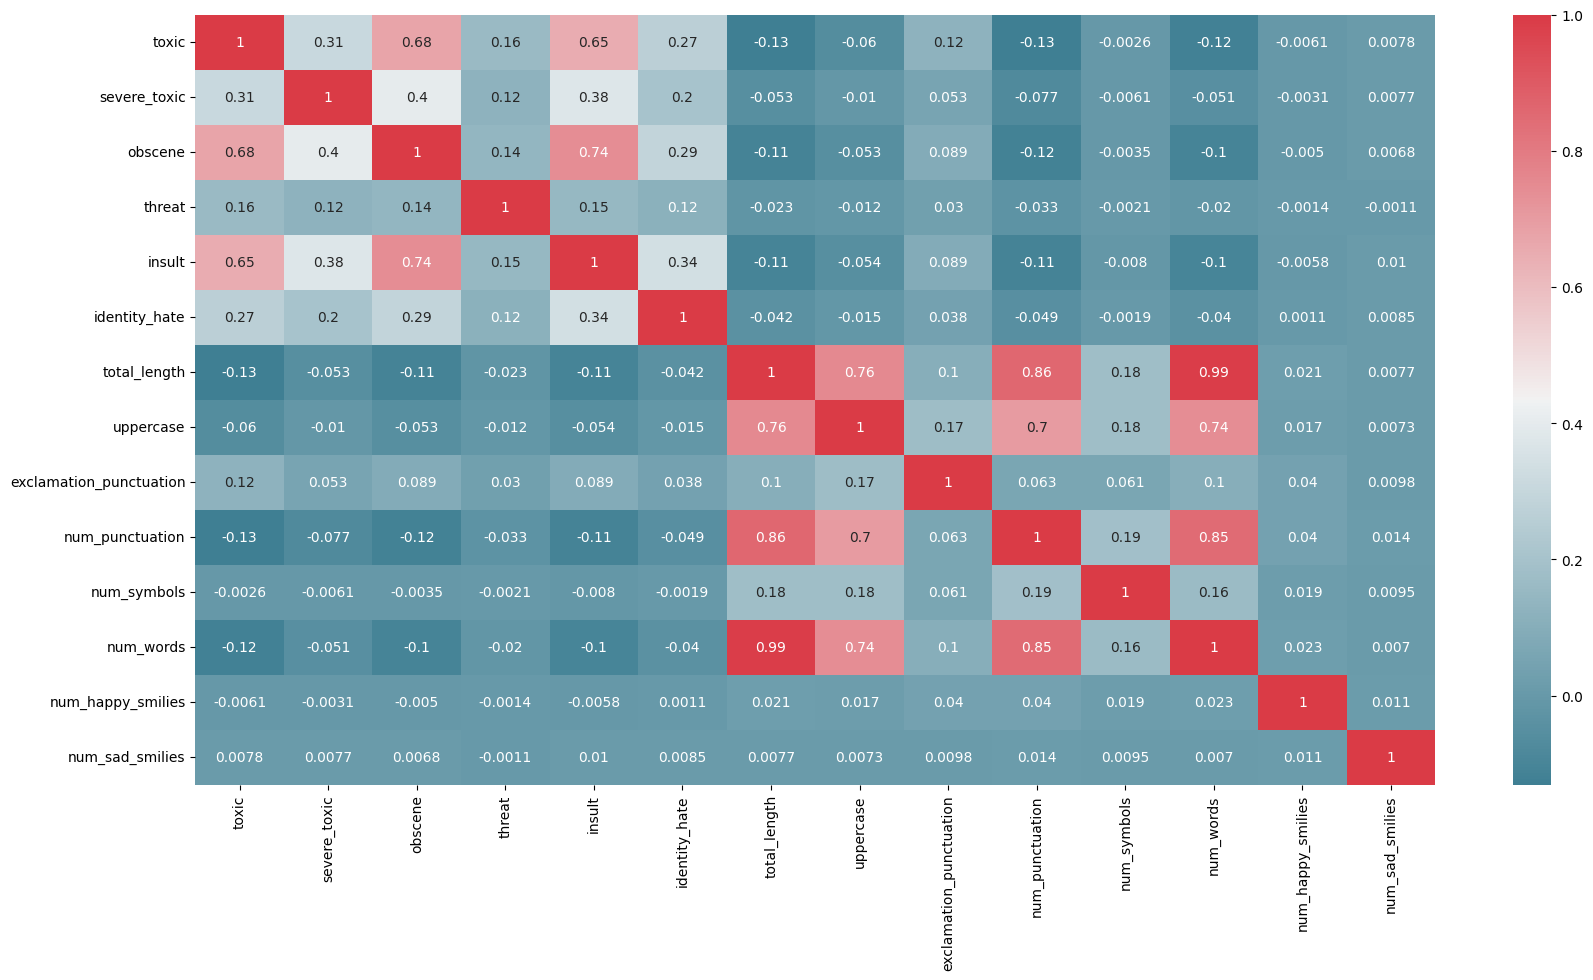

In [11]:
# Spearman correlation.

#corr = train_data.corr(method='spearman')

# Fixed the above line to compute Spearman correlation only for numeric features
corr = train_data.select_dtypes(include=[np.number]).corr(method='spearman')

f, ax = plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, annot = True)

In [12]:
# let's drop one of the features which have a high correlation with another feature
# in our case, num_words have a very high correlation with the total length

train_data = train_data.drop(['num_words'], axis = 1)

<Axes: >

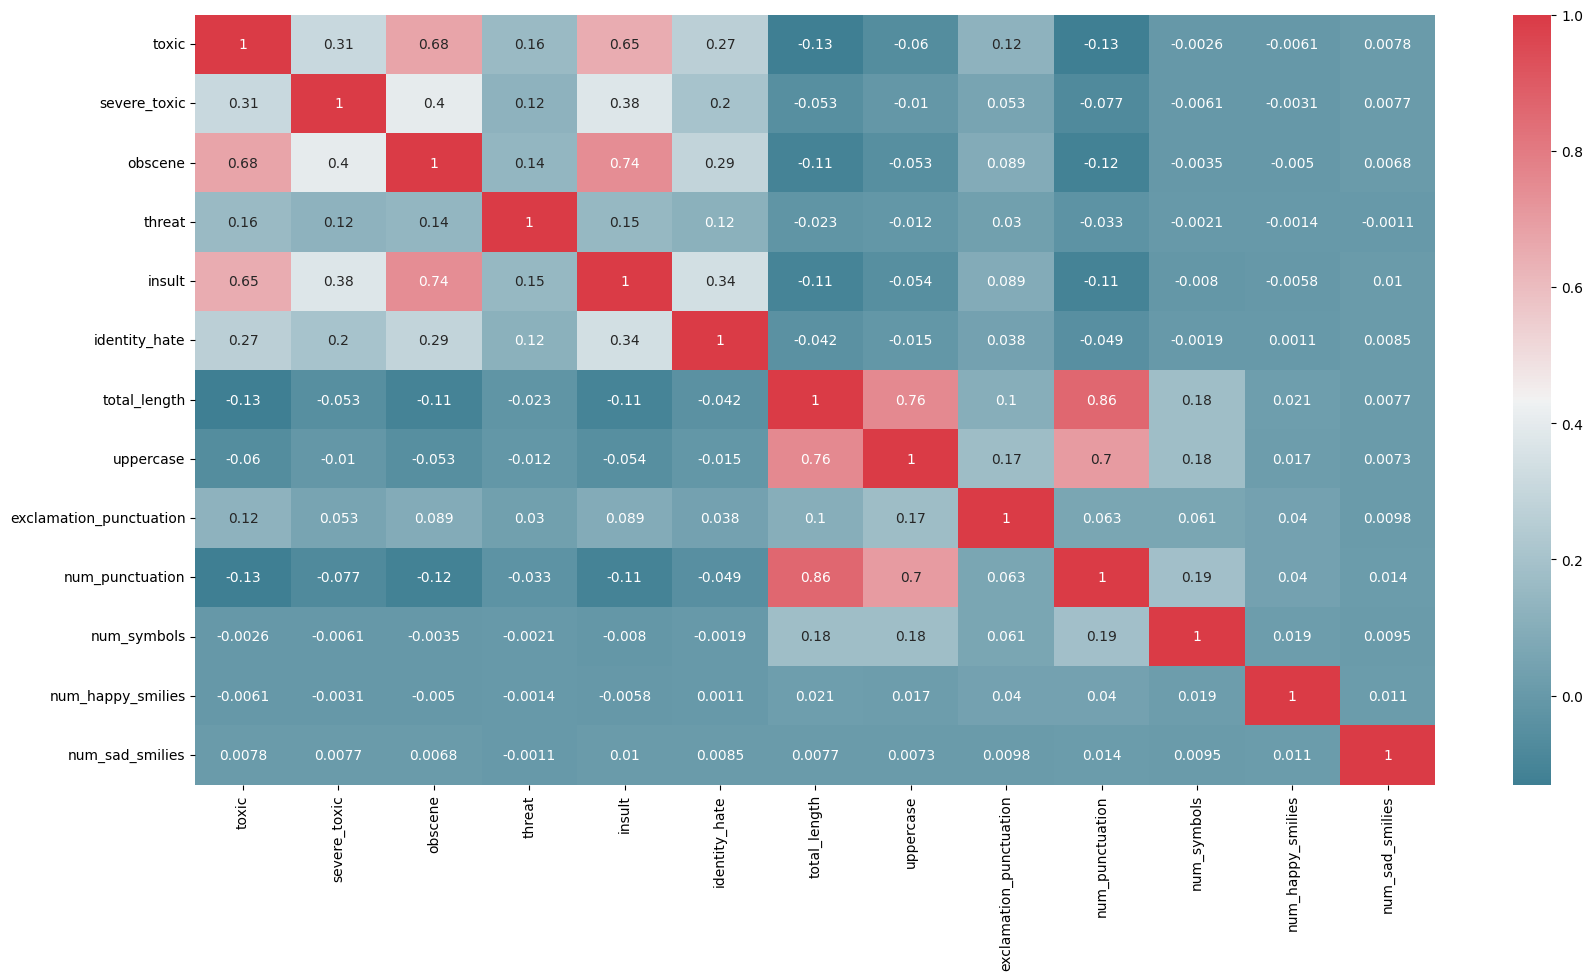

In [13]:
# Spearman correlation.

#corr = train_data.corr(method='spearman')

# Fixed the above line to compute Spearman correlation only for numeric features
corr = train_data.select_dtypes(include=[np.number]).corr(method='spearman')

f, ax = plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, annot = True)

In [14]:
train_features_data = train_data
train_features_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_length,uppercase,exclamation_punctuation,num_punctuation,num_symbols,num_happy_smilies,num_sad_smilies
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,17,0,7,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,8,1,5,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,4,0,4,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,11,0,6,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,2,0,4,0,0,0


> ## Explore each type of toxic comments:

In [15]:
train_features_data['toxic_type'] = ''
train_features_data['toxic_type'].loc[train_features_data['toxic'] == 1] += 'toxic '
train_features_data['toxic_type'].loc[train_features_data['severe_toxic'] == 1] += 'severe_toxic '
train_features_data['toxic_type'].loc[train_features_data['obscene'] == 1] += 'obscene '
train_features_data['toxic_type'].loc[train_features_data['threat'] == 1] += 'threat '
train_features_data['toxic_type'].loc[train_features_data['insult'] == 1] += 'insult '
train_features_data['toxic_type'].loc[train_features_data['identity_hate'] == 1] += 'identity_hate '

In [16]:
table_top = train_features_data['toxic_type'].value_counts().to_frame()[:10].style.background_gradient(cmap=cmap)
table_top

,count
toxic_type,
,143346
toxic,5666
toxic obscene insult,3800
toxic obscene,1758
toxic insult,1215
toxic severe_toxic obscene insult,989
toxic obscene insult identity_hate,618
obscene,317
insult,301


The fisrt value is ''. It means, we have a lot of comment without any toxic.

In [17]:
train_features_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_length,uppercase,exclamation_punctuation,num_punctuation,num_symbols,num_happy_smilies,num_sad_smilies,toxic_type
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,17,0,7,0,0,0,
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,8,1,5,0,0,0,
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,4,0,4,0,0,0,
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,11,0,6,0,0,0,
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,2,0,4,0,0,0,


### Explore length of comments:

In [18]:
df_toxic = train_features_data.loc[train_features_data['toxic'] == 1]
df_severe_toxic = train_features_data.loc[train_features_data['severe_toxic'] == 1]
df_obscene = train_features_data.loc[train_features_data['obscene'] == 1]
df_threat = train_features_data.loc[train_features_data['threat'] == 1]
df_insult = train_features_data.loc[train_features_data['insult'] == 1]
df_identity_hate = train_features_data.loc[train_features_data['identity_hate'] == 1]
df_normal = train_features_data.loc[train_features_data['toxic_type'] == '']

In [19]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Histogram(x=df_toxic.total_length, name='toxic'))
fig.add_trace(go.Histogram(x=df_severe_toxic.total_length, name='severe_toxic'))
fig.add_trace(go.Histogram(x=df_obscene.total_length, name='obscene'))
fig.add_trace(go.Histogram(x=df_threat.total_length, name='threat'))
fig.add_trace(go.Histogram(x=df_insult.total_length, name='insult'))
fig.add_trace(go.Histogram(x=df_identity_hate.total_length, name='identity hate'))
fig.add_trace(go.Histogram(x=df_normal.total_length, name='normal'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.5)
fig.show()

Well, assumption about length is true. Non-toxic comments have a higher length.

### Explore how much types has each comment:

- how much types has each comments;
- visualization means for that;


In [20]:
train_features_data['list_toxic_type'] = train_features_data['toxic_type'].apply(lambda row: row.split(' '))
train_features_data['list_toxic_type'] =train_features_data['list_toxic_type'].apply(lambda row: len(row)-1)
table_types = train_features_data['list_toxic_type'].value_counts().to_frame().style.background_gradient(cmap=cmap)
table_types

,count
list_toxic_type,
0,143346
1,6360
3,4209
2,3480
4,1760
5,385
6,31


In [21]:
train_features_data['list_toxic_type'].loc[train_features_data['list_toxic_type']==0] = 'normal comment'
train_features_data['list_toxic_type'].loc[train_features_data['list_toxic_type']==1] = 'has one type of toxic'
train_features_data['list_toxic_type'].loc[train_features_data['list_toxic_type']==2] = 'has two types of toxic'
train_features_data['list_toxic_type'].loc[train_features_data['list_toxic_type']==3] = 'has three types of toxic'
train_features_data['list_toxic_type'].loc[train_features_data['list_toxic_type']==4] = 'has four types of toxic'
train_features_data['list_toxic_type'].loc[train_features_data['list_toxic_type']==5] = 'has five types of toxic'
train_features_data['list_toxic_type'].loc[train_features_data['list_toxic_type']==6] = 'has six types of toxic'

In [22]:
types = ['normal comment', 'has one type of toxic', 'has two types of toxic', 'has three types of toxic',
         'has four types of toxic', 'has five types of toxic', 'has six types of toxic']

columns = ['total_length', 'uppercase', 'exclamation_punctuation',
                                'num_punctuation', 'num_symbols', 'num_happy_smilies', 'num_sad_smilies']

df_mean = pd.DataFrame(columns=columns)

In [23]:
for i, toxic_type in enumerate(types):
    for col in columns:
        df_mean.at[i, col] = train_features_data[col].loc[train_features_data['list_toxic_type'] == toxic_type].mean()

In [24]:
df_mean['toxic_types'] = types

In [25]:
 df_mean

,total_length,uppercase,exclamation_punctuation,num_punctuation,num_symbols,num_happy_smilies,num_sad_smilies,toxic_types
0,404.347174,14.236993,0.343442,8.635274,0.114332,0.006795,0.00037,normal comment
1,348.78978,32.999686,2.578931,7.840094,0.145755,0.007075,0.000629,has one type of toxic
2,252.16408,26.932471,1.770115,6.103448,0.135632,0.002874,0.000575,has two types of toxic
3,241.639582,36.530767,3.648135,5.050368,0.14374,0.006177,0.000713,has three types of toxic
4,371.539773,106.406818,9.486364,6.152841,0.125,0.003409,0.003409,has four types of toxic
5,361.423377,124.948052,4.264935,7.031169,0.197403,0.012987,0.0,has five types of toxic
6,488.870968,149.064516,2.903226,13.032258,0.0,0.0,0.0,has six types of toxic


In [26]:
df_mean['total_length'] = pd.to_numeric(df_mean['total_length'])
df_mean['uppercase'] = pd.to_numeric(df_mean['uppercase'])
df_mean['exclamation_punctuation'] = pd.to_numeric(df_mean['exclamation_punctuation'])
df_mean['num_punctuation'] = pd.to_numeric(df_mean['num_punctuation'])
df_mean['num_symbols'] = pd.to_numeric(df_mean['num_symbols'])
df_mean['num_happy_smilies'] = pd.to_numeric(df_mean['num_happy_smilies'])
df_mean['num_sad_smilies'] = pd.to_numeric(df_mean['num_sad_smilies'])

In [27]:
import plotly.express as px


px.scatter(df_mean, x="exclamation_punctuation", y="num_punctuation",
           size="total_length", color="toxic_types", hover_name="toxic_types",
           size_max=55)

- the comments with four toxic types are far from others;
- the comments with six toxic types have a lot of punctuation and an average number of exclamation punctuation;
- the normal types of comments have an average number of  punctuation and a low number of exclamation punctuation.

### Explore each toxic type:

In [28]:
types = ['toxic', 'severe_toxic', 'obscene', 'threat',
         'insult', 'identity_hate']

df_types_mean = pd.DataFrame(columns=columns)

In [29]:
for i, toxic_type in enumerate(types):
    for col in columns:
        df_types_mean.at[i, col] = train_features_data[col].loc[train_features_data[toxic_type] == 1].mean()

In [30]:
for col in columns:
        df_types_mean.at[6, col] = train_features_data[col].loc[train_features_data['toxic'] == 0] \
                                                        .loc[train_features_data['severe_toxic'] == 0] \
                                                        .loc[train_features_data['obscene'] == 0] \
                                                        .loc[train_features_data['threat'] == 0] \
                                                        .loc[train_features_data['insult'] == 0] \
                                                        .loc[train_features_data['identity_hate'] == 0] \
                                                        .mean()

In [31]:
df_types_mean

,total_length,uppercase,exclamation_punctuation,num_punctuation,num_symbols,num_happy_smilies,num_sad_smilies
0,295.246044,44.190859,3.631686,6.334772,0.142997,0.005623,0.000915
1,453.63511,154.927273,16.275862,6.983699,0.189969,0.004389,0.002508
2,286.784827,50.508818,3.330098,6.076932,0.139306,0.005444,0.001065
3,307.740586,76.297071,16.822176,7.441423,0.133891,0.004184,0.0
4,277.284753,49.329821,3.731497,5.684017,0.119843,0.005078,0.001396
5,308.540925,72.030605,2.311744,5.474733,0.192883,0.007829,0.002135
6,404.347174,14.236993,0.343442,8.635274,0.114332,0.006795,0.00037


In [32]:
types.append('normal comment')

df_types_mean['type'] = types
df_types_mean

,total_length,uppercase,exclamation_punctuation,num_punctuation,num_symbols,num_happy_smilies,num_sad_smilies,type
0,295.246044,44.190859,3.631686,6.334772,0.142997,0.005623,0.000915,toxic
1,453.63511,154.927273,16.275862,6.983699,0.189969,0.004389,0.002508,severe_toxic
2,286.784827,50.508818,3.330098,6.076932,0.139306,0.005444,0.001065,obscene
3,307.740586,76.297071,16.822176,7.441423,0.133891,0.004184,0.0,threat
4,277.284753,49.329821,3.731497,5.684017,0.119843,0.005078,0.001396,insult
5,308.540925,72.030605,2.311744,5.474733,0.192883,0.007829,0.002135,identity_hate
6,404.347174,14.236993,0.343442,8.635274,0.114332,0.006795,0.00037,normal comment


In [33]:
df_types_mean['total_length'] = pd.to_numeric(df_types_mean['total_length'])
df_types_mean['uppercase'] = pd.to_numeric(df_types_mean['uppercase'])
df_types_mean['exclamation_punctuation'] = pd.to_numeric(df_types_mean['exclamation_punctuation'])
df_types_mean['num_punctuation'] = pd.to_numeric(df_types_mean['num_punctuation'])
df_types_mean['num_symbols'] = pd.to_numeric(df_types_mean['num_symbols'])
df_types_mean['num_happy_smilies'] = pd.to_numeric(df_types_mean['num_happy_smilies'])
df_types_mean['num_sad_smilies'] = pd.to_numeric(df_types_mean['num_sad_smilies'])

In [34]:
px.scatter(df_types_mean, x="exclamation_punctuation", y="num_punctuation",
           size="total_length", color="type", hover_name="type",
           size_max=55)

In [35]:
fig = px.scatter_3d(df_types_mean, x='exclamation_punctuation', y='num_punctuation', z='uppercase', size='total_length', color='type',
                    hover_data=['type'])
fig.update_layout(scene_zaxis_type="log")
fig.show()

- we can see four "clusters": 1 - threat, severe toxic, 2 -  normal comments, 3 - toxic, obscene, insult, identity hate.

In [36]:
px.scatter(df_types_mean, x="uppercase", y="num_punctuation",
           size="total_length", color="type", hover_name="type",
           size_max=55)

In [37]:
px.scatter(df_types_mean, x="uppercase", y="num_symbols",
           size="total_length", color="type", hover_name="type",
           size_max=55)

In [38]:
px.scatter(df_types_mean, x="uppercase", y="exclamation_punctuation",
           size="total_length", color="type", hover_name="type",
           size_max=55)

- in each case we can see that severe toxic is far from other types;
- toxic, insult, obscene always are very close;
- normal comments always at the origin of coordinates;

**It`s not final version.**


# Logistic regression with TF-IDF and numeric features:

## TF-IDF for comments (text data):

In [39]:
tvec = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000
)

tvec.fit(train_data['comment_text'])

train_texts = tvec.transform(train_data['comment_text'])
test_texts = tvec.transform(test_data['comment_text'])

## DataFrameMapper for joining numerical and text features:

In [40]:
# If we want to work with frames from pandas for algorithms in Scikit-Learn, we could use a special module for that - Sklearn-pandas
# This module provides a bridge between Scikit-Learn's machine learning methods and pandas-style Data Frames.

mapper = DataFrameMapper([
      (['uppercase'], StandardScaler()),
      (['exclamation_punctuation'], StandardScaler()),
      (['num_punctuation'], StandardScaler()),
      (['num_symbols'], StandardScaler()),
      (['num_happy_smilies'],StandardScaler()),
      (['num_sad_smilies'],StandardScaler()),
      (['total_length'],StandardScaler())
], df_out=True)

In [41]:
numeric_features_train = train_data.iloc[:, 8:15]
numeric_features_train.head()

,total_length,uppercase,exclamation_punctuation,num_punctuation,num_symbols,num_happy_smilies,num_sad_smilies
0,264,17,0,7,0,0,0
1,112,8,1,5,0,0,0
2,233,4,0,4,0,0,0
3,622,11,0,6,0,0,0
4,67,2,0,4,0,0,0


In [42]:
x_train = np.round(mapper.fit_transform(numeric_features_train.copy()), 2).values
x_train

array([[-0.  , -0.03, -0.11, ..., -0.07, -0.02, -0.22],
       [-0.09,  0.01, -0.26, ..., -0.07, -0.02, -0.48],
       [-0.14, -0.03, -0.34, ..., -0.07, -0.02, -0.27],
       ...,
       [-0.14, -0.03, -0.41, ..., -0.07, -0.02, -0.53],
       [-0.16, -0.03, -0.56, ..., -0.07, -0.02, -0.47],
       [-0.14, -0.03, -0.11, ..., -0.07, -0.02, -0.35]])

In [43]:
x_train_features = sparse.hstack((csr_matrix(x_train), train_texts))

In [44]:
numeric_features_test = test_data.iloc[:, 1:]
numeric_features_test.head()

,comment_text,total_length,uppercase,exclamation_punctuation,num_punctuation,num_symbols,num_words,num_happy_smilies,num_sad_smilies
0,Yo bitch Ja Rule is more succesful then you'll...,367,4,0,11,0,72,0,0
1,== From RfC == \n\n The title is fine as it is...,50,7,0,2,0,12,0,0
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54,4,0,0,1,12,0,0
3,":If you have a look back at the source, the in...",205,4,0,5,0,38,0,0
4,I don't anonymously edit articles at all.,41,1,0,1,0,7,0,0


In [45]:
x_test = np.round(mapper.fit_transform(numeric_features_test.copy()), 2).values
x_test

array([[-0.11, -0.03,  0.12, ..., -0.06, -0.03,  0.  ],
       [-0.09, -0.03, -0.31, ..., -0.06, -0.03, -0.53],
       [-0.11, -0.03, -0.41, ..., -0.06, -0.03, -0.52],
       ...,
       [-0.03, -0.03,  0.45, ..., -0.06, -0.03,  0.1 ],
       [ 0.03, -0.03, -0.03, ..., -0.06, -0.03,  0.23],
       [-0.12, -0.03, -0.03, ..., -0.06, -0.03, -0.38]])

In [46]:
x_test_features = sparse.hstack((csr_matrix(x_test), test_texts))

In [47]:
train_features = x_train_features
test_features  = x_test_features

In [48]:
scores = []
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for class_name in class_names:
  train_target = train_data[class_name]
  classifier = LogisticRegression(C=0.1, solver='sag')
  cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
  scores.append(cv_score)
  print('CV score for class {} is {}'.format(class_name, cv_score))

  classifier.fit(train_features, train_target)

print('Total CV score is {}'.format(np.mean(scores)))

CV score for class toxic is 0.8596897464471315
CV score for class severe_toxic is 0.8563062474594706
CV score for class obscene is 0.8749242163266056
CV score for class threat is 0.7194107475041198
CV score for class insult is 0.8529864521818471
CV score for class identity_hate is 0.7759808264581046
Total CV score is 0.8232163727295464




---


### **This section is where our code for the audit begins:**



In [69]:
# starting from this code cell and below, the code is for the later parts of the project report
numeric_features = ['total_length', 'uppercase', 'exclamation_punctuation', 'num_punctuation', 'num_symbols']
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [71]:
# re-adding the 'num_words' variable back into the dataset since it was dropped in the original notebook code above
train_data['num_words'] = train_data['comment_text'].apply(lambda x: len(str(x).split()))

# now printing summary statistics for all numerical variables

train_data[numeric_features].describe()

,total_length,uppercase,exclamation_punctuation,num_punctuation,num_symbols
count,159571.000000,159571.000000,159571.000000,159571.00000,159571.000000
mean,394.073221,17.159628,0.661624,8.42341,0.117120
std,590.720282,96.528103,25.899553,13.17102,1.093046
min,6.000000,0.000000,0.000000,0.00000,0.000000
25%,96.000000,3.000000,0.000000,2.00000,0.000000
50%,205.000000,7.000000,0.000000,5.00000,0.000000
75%,435.000000,15.000000,0.000000,9.00000,0.000000
max,5000.000000,4960.000000,4942.000000,683.00000,148.000000


In [72]:
# checking the proportion of non-toxic comments
non_toxic_only = train_data[(train_data[class_names] == 0).all(axis=1)]
non_toxic_ratio = len(non_toxic_only) / len(train_data)
print(f"Non-toxic proportion: {non_toxic_ratio:.4f}")

Non-toxic proportion: 0.8983


In [73]:
# counting each unique label combination
combo_counts = train_data[class_names].value_counts().sort_values(ascending=False)

# converting to percentages
combo_percentages = (combo_counts / len(train_data)) * 100

# displaying the top combinations and their percentages
combo_df = combo_percentages.reset_index()
combo_df.columns = class_names + ['percentage']
print(combo_df.head(10))

# showing the tail for the rarest
print("\nRarest combinations:")
print(combo_df.tail(10))

   toxic  severe_toxic  obscene  threat  insult  identity_hate  percentage
0      0             0        0       0       0              0   89.832112
1      1             0        0       0       0              0    3.550771
2      1             0        1       0       1              0    2.381385
3      1             0        1       0       0              0    1.101704
4      1             0        0       0       1              0    0.761417
5      1             1        1       0       1              0    0.619787
6      1             0        1       0       1              1    0.387288
7      0             0        1       0       0              0    0.198658
8      0             0        0       0       1              0    0.188631
9      1             1        1       0       1              1    0.166070

Rarest combinations:
    toxic  severe_toxic  obscene  threat  insult  identity_hate  percentage
31      1             1        1       0       0              1    0.003760
3

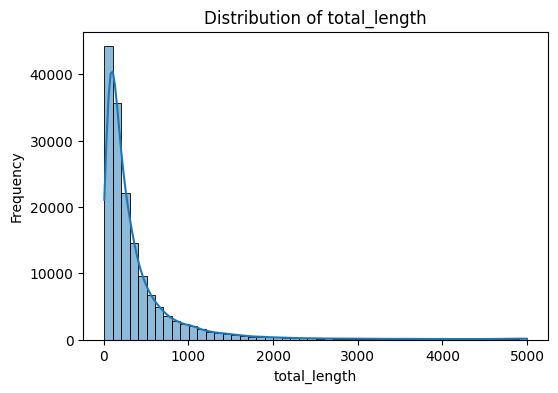

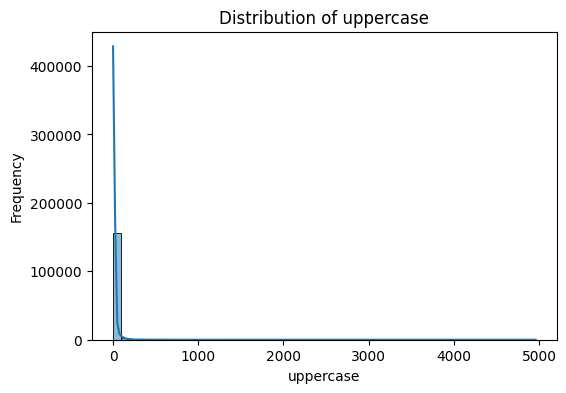

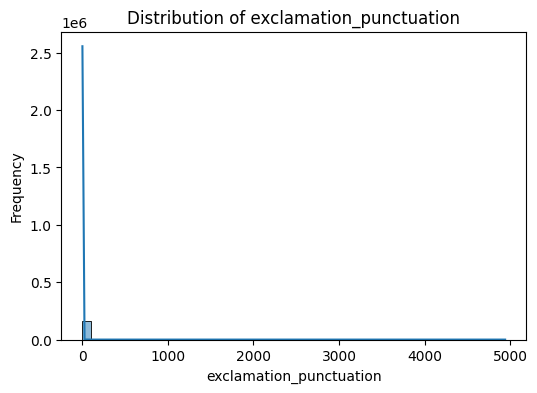

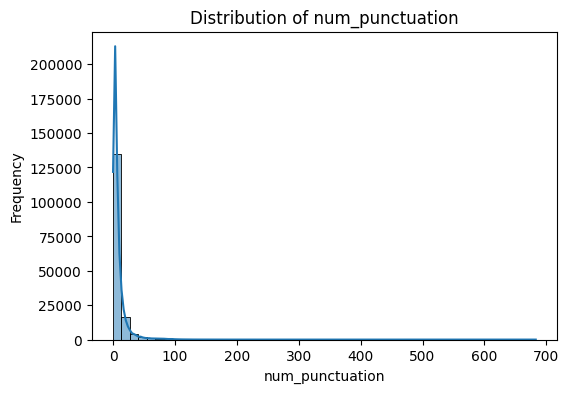

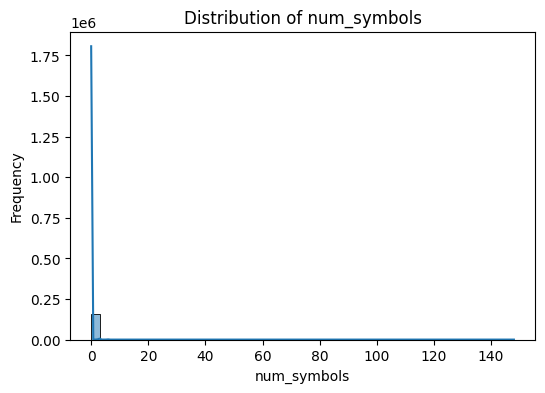

In [74]:
# plotting the distributions of each feature
import matplotlib.pyplot as plt
import seaborn as sns

for feature in numeric_features:
    plt.figure(figsize=(6,4))
    sns.histplot(train_data[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In [75]:
test_labels = pd.read_csv("test_labels.csv")

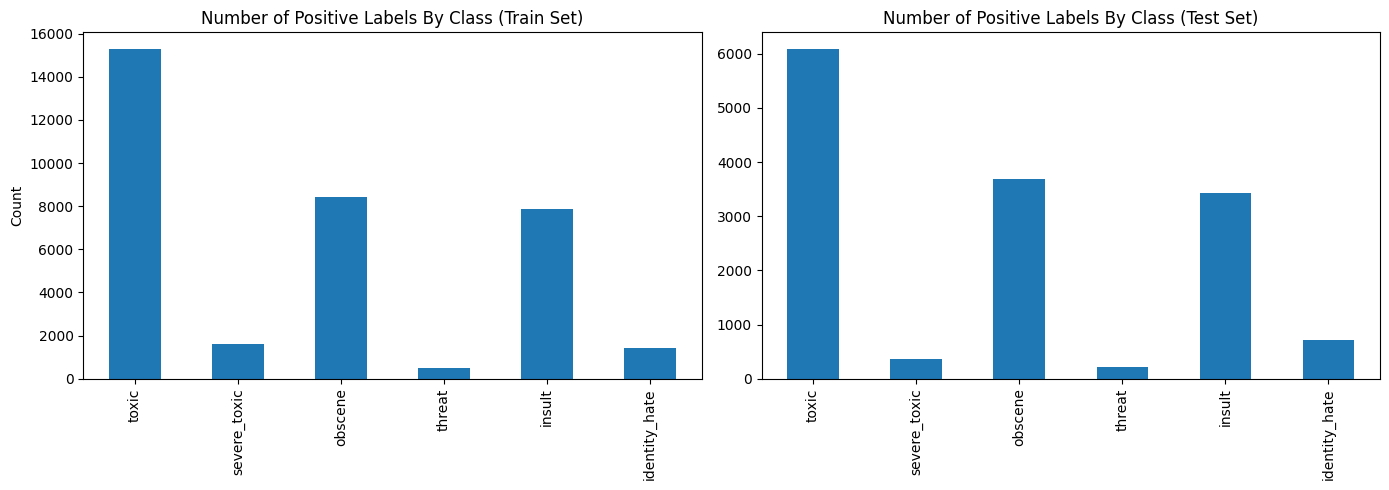

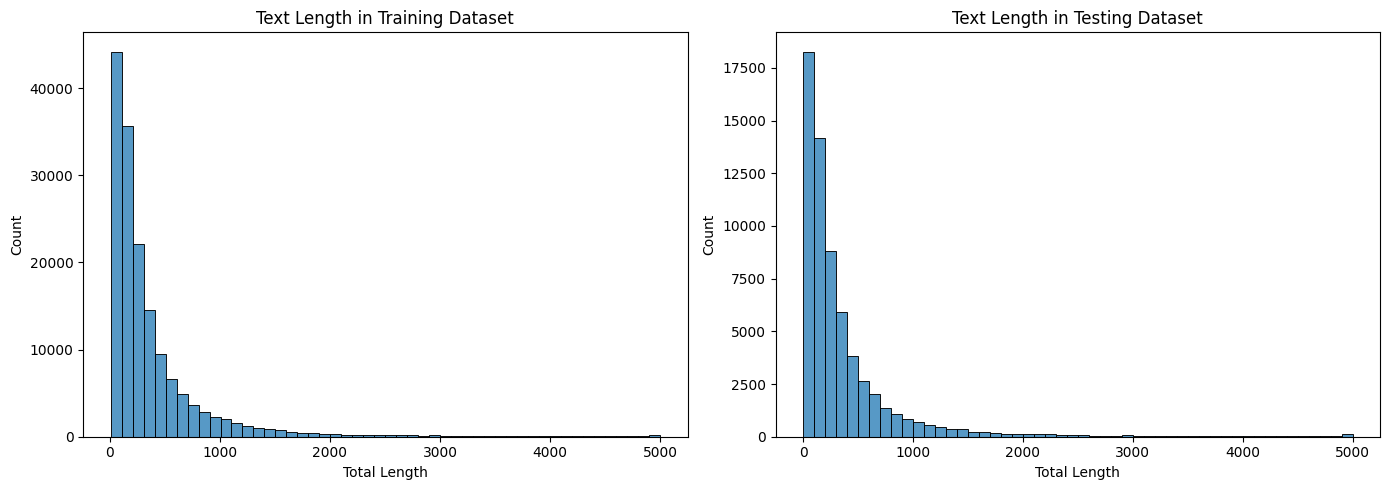

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# filter out rows with -1 in any label
filtered_labels = test_labels[test_labels[labels].min(axis=1) >= 0]

# merge with test.csv to get comment text and calculate text length
valid_test_labels = test_data.merge(filtered_labels, on="id")
valid_test_labels["total_length"] = valid_test_labels["comment_text"].apply(len)

# compare label counts in train and test
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
train_data[labels].sum().plot(kind='bar', ax=axes[0])
axes[0].set_title("Number of Positive Labels By Class (Train Set)")
axes[0].set_ylabel("Count")

valid_test_labels[labels].sum().plot(kind='bar', ax=axes[1])
axes[1].set_title("Number of Positive Labels By Class (Test Set)")

plt.tight_layout()
plt.show()

# compare comment length distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(train_data['total_length'], bins=50, kde=False, ax=axes[0])
axes[0].set_title("Text Length in Training Dataset")
axes[0].set_xlabel("Total Length")

sns.histplot(valid_test_labels['total_length'], bins=50, kde=False, ax=axes[1])
axes[1].set_title("Text Length in Testing Dataset")
axes[1].set_xlabel("Total Length")

plt.tight_layout()
plt.show()


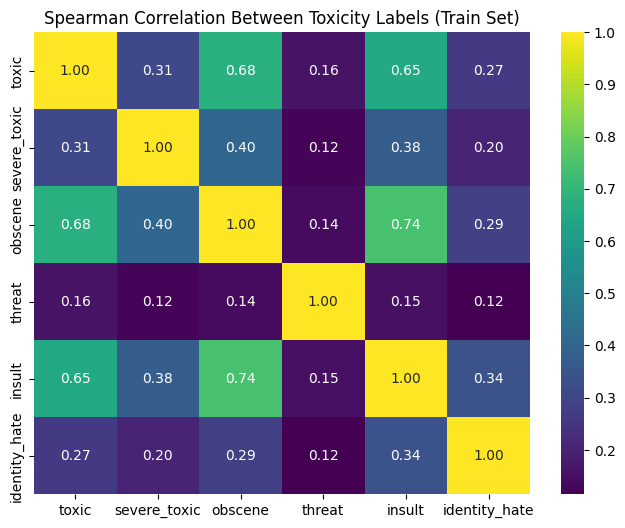

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# calculate Spearman correlation among labels in the training set
label_correlation = train_data[labels].corr(method='spearman')

# plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(label_correlation, annot=True, cmap="viridis", fmt=".2f")
plt.title("Spearman Correlation Between Toxicity Labels (Train Set)")
plt.show()

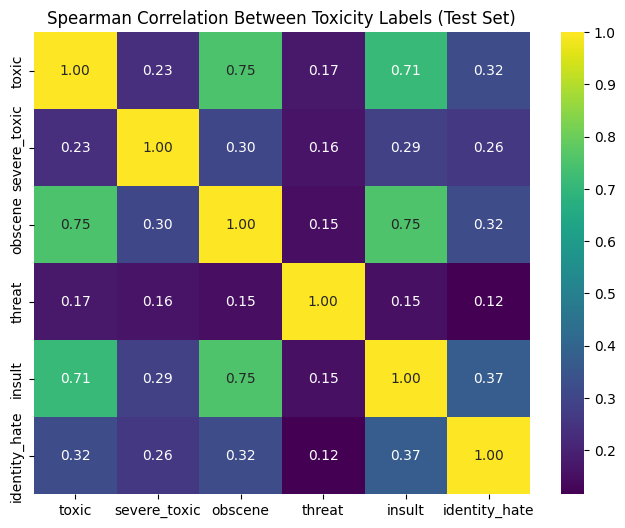

In [78]:
# loading the test set labels file since they were not loaded before
test_labels = pd.read_csv("test_labels.csv")

# remove rows with withheld labels (-1)
valid_test_labels = test_labels[test_labels[labels].min(axis=1) >= 0]

# calculate Spearman correlation
test_label_corr = valid_test_labels[labels].corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(test_label_corr, annot=True, cmap="viridis", fmt=".2f")
plt.title("Spearman Correlation Between Toxicity Labels (Test Set)")
plt.show()


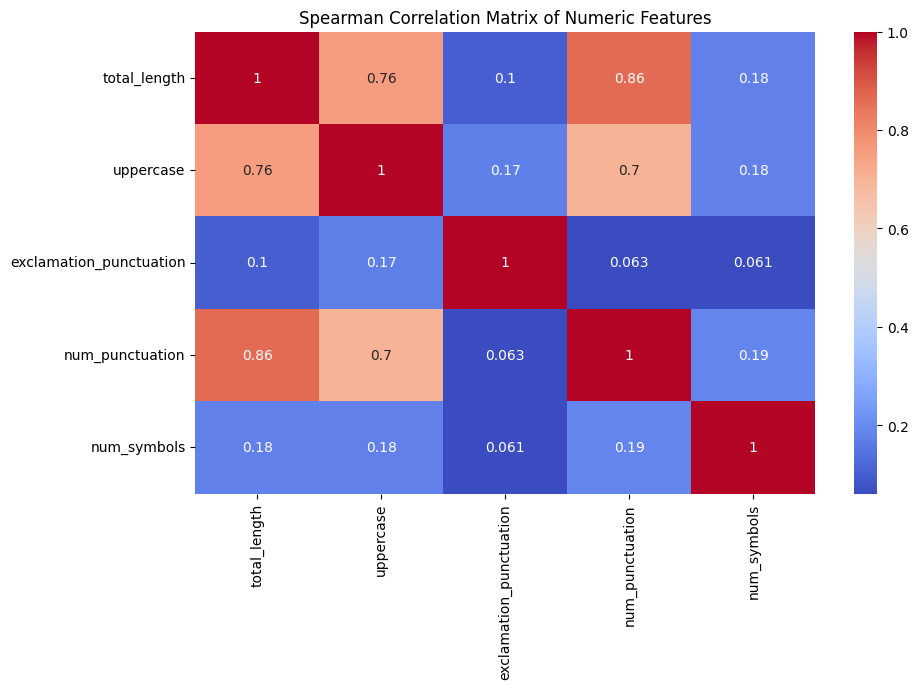

In [79]:
# the original notebook code already does this, but for the sake of our audit, let's look at the pairwise correlations between features
corr = train_data[numeric_features].corr(method='spearman')

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix of Numeric Features')
plt.show()

In [80]:
# now we are re-dropping the 'num_words' variable since it is highly correlated with the 'total_length' variable
# which can create multicollinearity or over-representation of length-based features in the model later on
train_data = train_data.drop('num_words', axis=1)


In [81]:
# frequency of identity-related mentions
identity_keywords = ['muslim', 'jew', 'jewish', 'christian', 'black', 'white',
                     'female', 'gay', 'lesbian', 'trans', 'hispanic', 'mexican', 'asian']

train_data['mentions_identity'] = train_data['comment_text'].str.lower().apply(
    lambda x: any(term in x for term in identity_keywords)
)

# count proportion of identity-related comments
train_data['mentions_identity'].value_counts(normalize=True)

,proportion
mentions_identity,
False,0.9372
True,0.0628


In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

# now we perform TF-IDF vectorization to prepare for PCA in the following step, since our data is text and not numeric
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X_tfidf = vectorizer.fit_transform(train_data['comment_text'])

In [83]:
# now doing PCA in the following step, reducing TF-IDF to 2D
from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(X_tfidf.toarray())

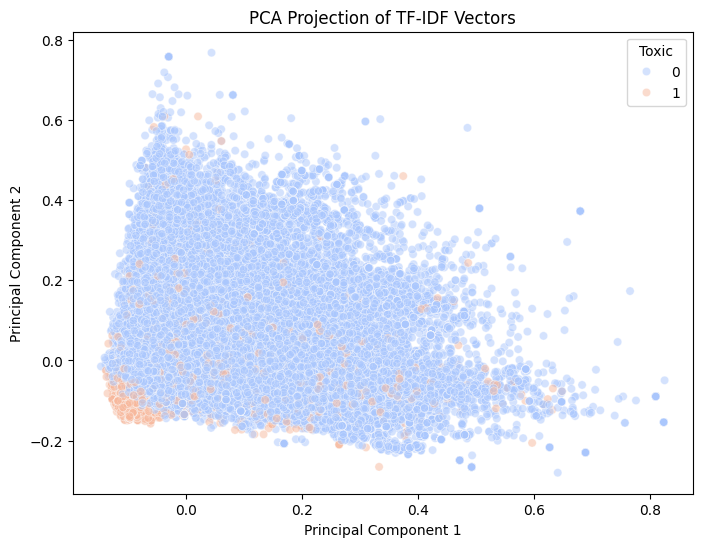

In [84]:
from sklearn.decomposition import PCA
import pandas as pd

# creating a visualization for PCA components for toxic vs non-toxic
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=train_data['toxic'], palette='coolwarm', alpha=0.5)
plt.title('PCA Projection of TF-IDF Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Toxic')
plt.show()


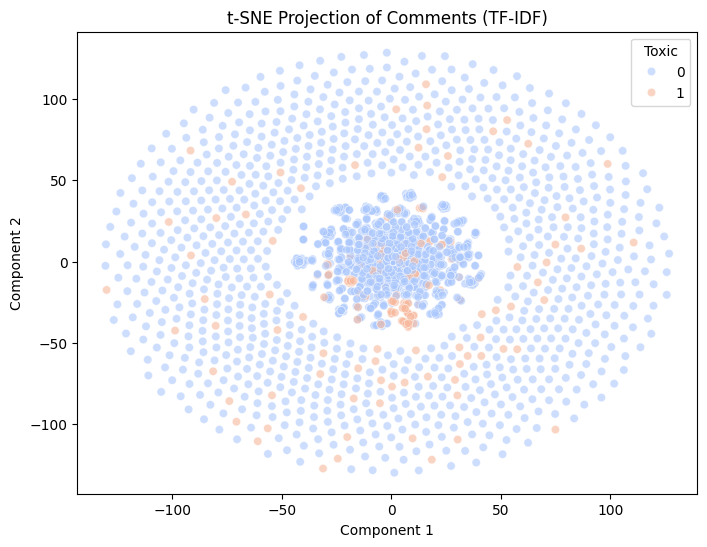

In [85]:
# now we are using t-SNE as a dimensionality reduction technique to visualize the TF-IDF representations of the comments
# this allows us to observe whether toxic or non-toxic comments form distinguishable clusters in the feature space (which offers insight into the separability of the labels)

from sklearn.manifold import TSNE

# using a small sample to avoid memory issues
sample_idx = train_data.sample(n=2000, random_state=42).index
X_sample = X_tfidf[sample_idx]
y_sample = train_data.loc[sample_idx, 'toxic']

# running t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sample.toarray())

# plotting the visualization
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_sample, palette='coolwarm', alpha=0.6)
plt.title('t-SNE Projection of Comments (TF-IDF)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Toxic')
plt.show()

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

print("Model Performance Without Upsampling")
metrics = []

for label in labels:
    X = train_data[numeric_features]
    y = train_data[label]

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X, y)
    y_pred = clf.predict(X)

    acc = accuracy_score(y, y_pred)
    rec = recall_score(y, y_pred)
    prec = precision_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    fnr = fn / (fn + tp + 1e-5)
    fpr = fp / (fp + tn + 1e-5)

    metrics.append([label, acc, rec, prec, fnr, fpr])
    print(f"{label:<15} Acc: {acc:.4f}, Recall: {rec:.4f}, Prec: {prec:.4f}, FNR: {fnr:.4f}, FPR: {fpr:.4f}")


Model Performance Without Upsampling
toxic           Acc: 0.9052, Recall: 0.0186, Prec: 0.7082, FNR: 0.9814, FPR: 0.0008
severe_toxic    Acc: 0.9900, Recall: 0.0238, Prec: 0.5205, FNR: 0.9762, FPR: 0.0002
obscene         Acc: 0.9472, Recall: 0.0077, Prec: 0.6075, FNR: 0.9923, FPR: 0.0003
threat          Acc: 0.9970, Recall: 0.0000, Prec: 0.0000, FNR: 1.0000, FPR: 0.0000
insult          Acc: 0.9507, Recall: 0.0070, Prec: 0.5851, FNR: 0.9930, FPR: 0.0003
identity_hate   Acc: 0.9912, Recall: 0.0014, Prec: 0.2222, FNR: 0.9986, FPR: 0.0000


In [87]:
!pip install imbalanced-learn --quiet
from imblearn.over_sampling import SMOTE

print("Model Performance With SMOTE Upsampling")

for label in labels:
    X = train_data[numeric_features]
    y = train_data[label]

    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_res, y_res)
    y_pred = clf.predict(X)

    acc = accuracy_score(y, y_pred)
    rec = recall_score(y, y_pred)
    prec = precision_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    fnr = fn / (fn + tp + 1e-5)
    fpr = fp / (fp + tn + 1e-5)

    print(f"{label:<15} Acc: {acc:.4f}, Recall: {rec:.4f}, Prec: {prec:.4f}, FNR: {fnr:.4f}, FPR: {fpr:.4f}")


Model Performance With SMOTE Upsampling
toxic           Acc: 0.5548, Recall: 0.7060, Prec: 0.1396, FNR: 0.2940, FPR: 0.4613
severe_toxic    Acc: 0.8922, Recall: 0.4483, Prec: 0.0420, FNR: 0.5517, FPR: 0.1033
obscene         Acc: 0.5038, Recall: 0.7554, Prec: 0.0764, FNR: 0.2446, FPR: 0.5103
threat          Acc: 0.4863, Recall: 0.7950, Prec: 0.0046, FNR: 0.2050, FPR: 0.5146
insult          Acc: 0.5004, Recall: 0.7479, Prec: 0.0704, FNR: 0.2521, FPR: 0.5125
identity_hate   Acc: 0.5071, Recall: 0.7395, Prec: 0.0131, FNR: 0.2605, FPR: 0.4950


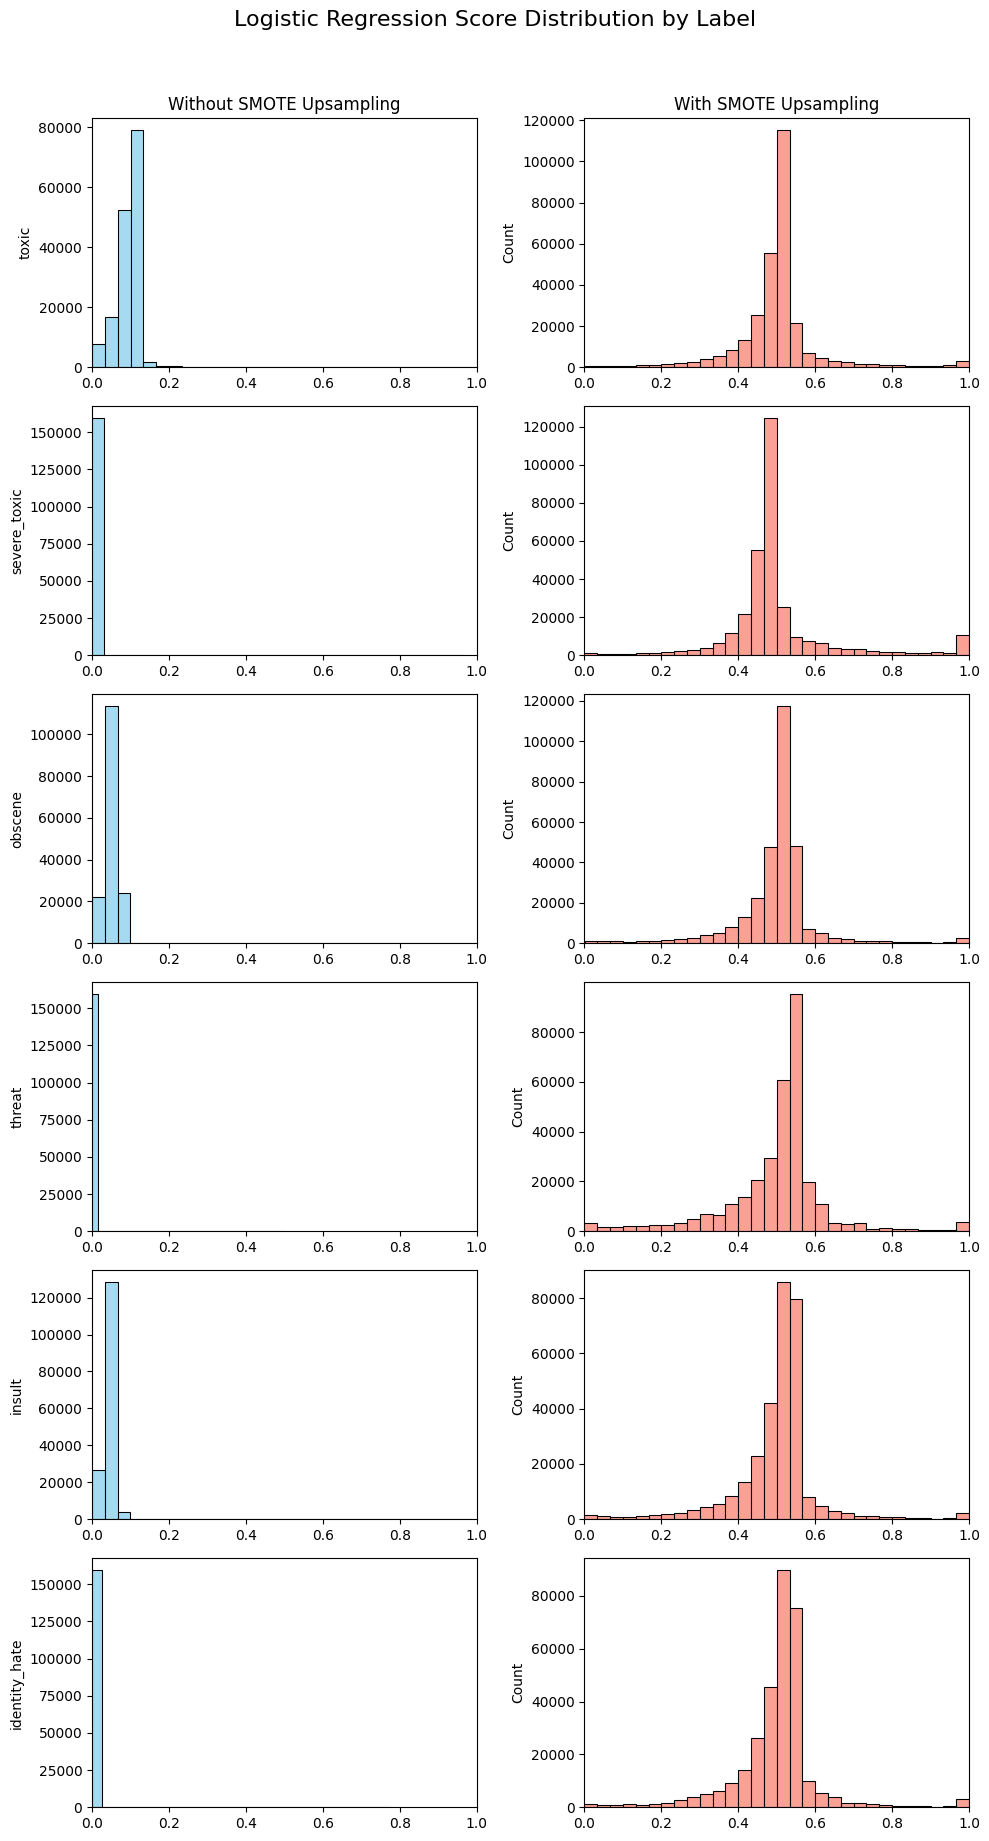

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# store probabilities
proba_dict_no_smote = {}
proba_dict_smote = {}

# fit models without SMOTE upsampling
for label in labels:
    X = train_data[numeric_features]
    y = train_data[label]
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X, y)
    probs = clf.predict_proba(X)[:, 1]
    proba_dict_no_smote[label] = probs

# fit models with SMOTE upsampling
for label in labels:
    X = train_data[numeric_features]
    y = train_data[label]
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_res, y_res)
    probs = clf.predict_proba(X_res)[:, 1]
    proba_dict_smote[label] = probs

# plot side by side (left: no upsampling, right: with SMOTE)
fig, axes = plt.subplots(nrows=len(labels), ncols=2, figsize=(10, 18))
fig.suptitle("Logistic Regression Score Distribution by Label", fontsize=16, y=1.02)

for i, label in enumerate(labels):
    sns.histplot(proba_dict_no_smote[label], bins=30, ax=axes[i, 0], kde=False, color='skyblue')
    axes[i, 0].set_xlim(0, 1)
    axes[i, 0].set_ylabel(label)
    if i == 0:
        axes[i, 0].set_title("Without SMOTE Upsampling")

    sns.histplot(proba_dict_smote[label], bins=30, ax=axes[i, 1], kde=False, color='salmon')
    axes[i, 1].set_xlim(0, 1)
    if i == 0:
        axes[i, 1].set_title("With SMOTE Upsampling")

plt.tight_layout()
plt.show()

In [106]:
!pip install lime --quiet

from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from google.colab import drive
import os

drive.mount('/content/drive')

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(train_data['comment_text'])
y = train_data['toxic']

clf = LogisticRegression(max_iter=1000)
clf.fit(X_tfidf, y)

pipeline = make_pipeline(vectorizer, clf)
explainer = LimeTextExplainer(class_names=['non-toxic', 'toxic'])

toxic_indices = train_data[train_data['toxic'] == 1].sample(n=5, random_state=42).index

save_dir = '/content/drive/MyDrive/lime_explanations'
os.makedirs(save_dir, exist_ok=True)

for i, idx in enumerate(toxic_indices):
    sample_text = train_data.loc[idx, 'comment_text']
    explanation = explainer.explain_instance(sample_text, pipeline.predict_proba, num_features=10)
    explanation.save_to_file(f"{save_dir}/lime_explanation_{i}.html")

print("LIME explanations saved to Google Drive at:", save_dir)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LIME explanations saved to Google Drive at: /content/drive/MyDrive/lime_explanations


In [ ]:
# False positives for toxic where identity is mentioned
fp_identity = train_data[
    (train_data['toxic'] == 0) &
    (train_data['pred_toxic'] == 1) &
    (train_data['mentions_identity'])
]
fp_identity[['comment_text']].head(5)

,comment_text
17004,"""No, what you've done is prove you're clueless..."
24854,Who is IAN? Please do not remove this message ...
31854,Shutup \n\n[[Who U think U is you gay nobody t...
35806,"""\n\nI simply cannot believe what you are sayi..."
46918,MILLAHNNA IS IAN THOMSON'S = 777 in multiples ...
